# Anomaly Detection
Detection of outliers and anomalies based on:
- Statistical Method
- ML Method using Isolation Forests

In [8]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

In [10]:
# Cell 2: Load Cleaned Data
df = pd.read_csv("../data/processed/cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values("Date", inplace=True)
df.head()

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y
0,0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,211.096358,8.106,False
277665,277665,29,5,2010-02-05,15552.08,False,B,93638,24.36,2.788,131.527903,10.064,False
277808,277808,29,6,2010-02-05,3200.22,False,B,93638,24.36,2.788,131.527903,10.064,False
277951,277951,29,7,2010-02-05,10820.05,False,B,93638,24.36,2.788,131.527903,10.064,False
278094,278094,29,8,2010-02-05,20055.64,False,B,93638,24.36,2.788,131.527903,10.064,False


In [12]:
# Cell 3: Aggregate Sales by Date (for time-series level anomaly detection)
sales_ts = df.groupby("Date")["Weekly_Sales"].sum().reset_index()
sales_ts.set_index("Date", inplace=True)
sales_ts.head()

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30


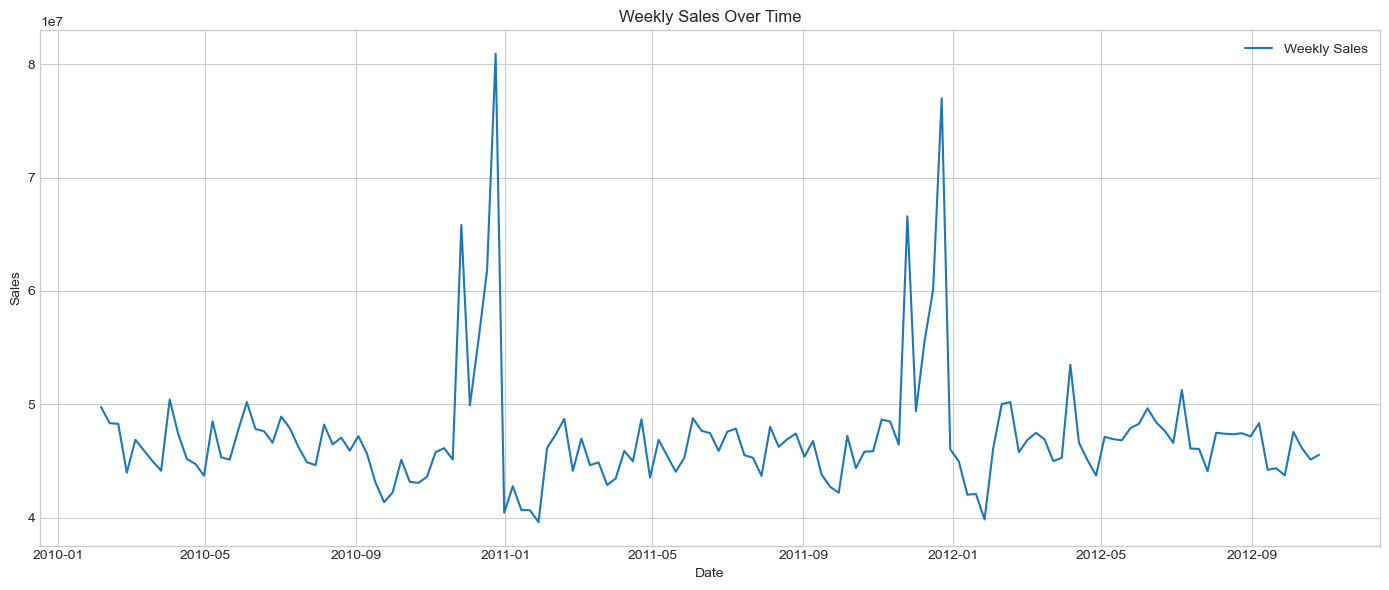

In [14]:
# Cell 4: Visualize Time Series
plt.figure(figsize=(14, 6))
plt.plot(sales_ts.index, sales_ts["Weekly_Sales"], label="Weekly Sales")
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

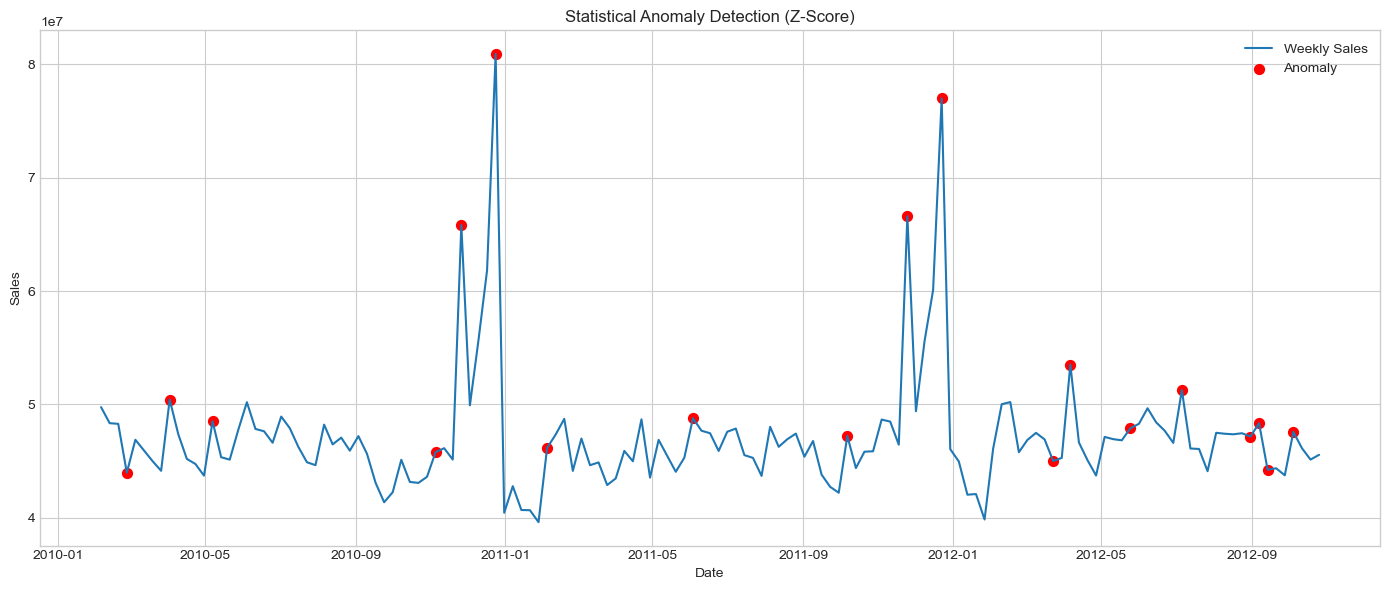

In [43]:
# Cell 5: Statistical Anomaly Detection using Z-Score
sales_ts["rolling_mean"] = sales_ts["Weekly_Sales"].rolling(window=4).mean()
sales_ts["rolling_std"] = sales_ts["Weekly_Sales"].rolling(window=4).std()
sales_ts["z_score"] = (sales_ts["Weekly_Sales"] - sales_ts["rolling_mean"]) / sales_ts["rolling_std"]

threshold = 1.39
sales_ts["anomaly_stat"] = sales_ts["z_score"].abs() > threshold

# Plot anomalies
plt.figure(figsize=(14, 6))
plt.plot(sales_ts.index, sales_ts["Weekly_Sales"], label="Weekly Sales")
plt.scatter(sales_ts[sales_ts["anomaly_stat"]].index, 
            sales_ts[sales_ts["anomaly_stat"]]["Weekly_Sales"],
            color="red", label="Anomaly", s=50)
plt.title("Statistical Anomaly Detection (Z-Score)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

When we do a statistical anomaly detection, it could detect no annomalies until we put the threshold very low (around 1.4)
Lets do an ML Based Annomaly Detection, using Isolation Forests

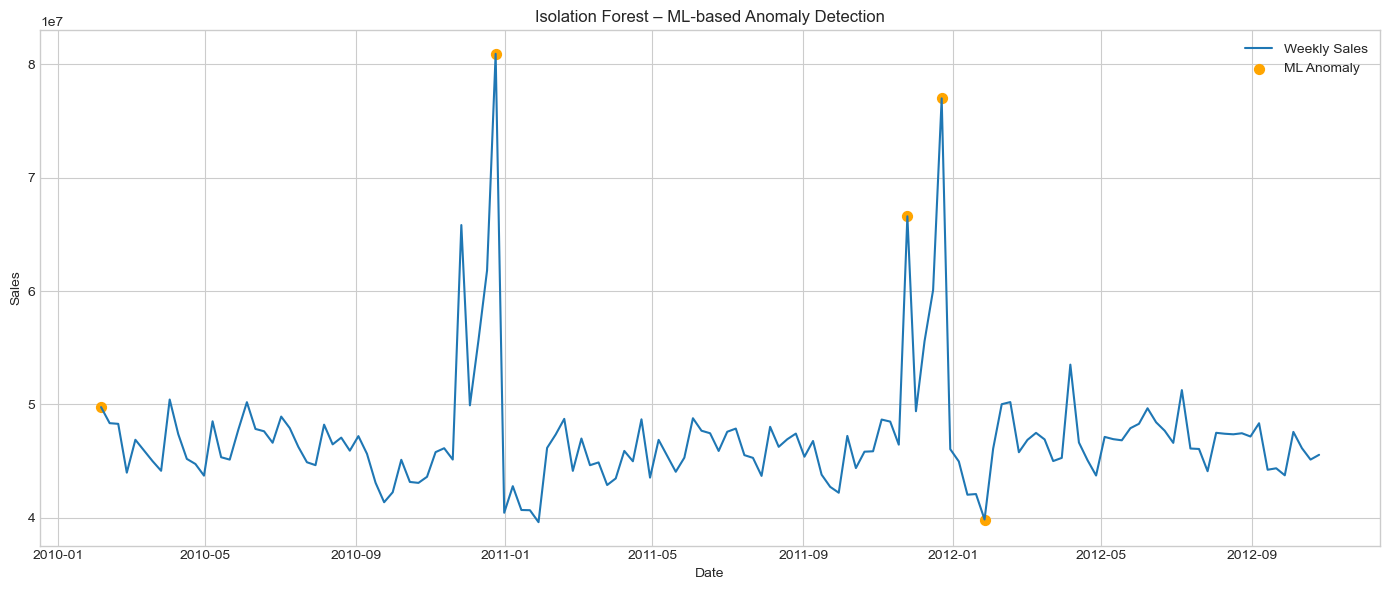

In [46]:
# Cell 6: `
# Use aggregated weekly sales + external features
features = df.groupby("Date").agg({
    "Weekly_Sales": "sum",
    "Temperature": "mean",
    "Fuel_Price": "mean",
    "CPI": "mean",
    "Unemployment": "mean"
}).reset_index()

features["Date"] = pd.to_datetime(features["Date"])
features.set_index("Date", inplace=True)

# Model training
model = IsolationForest(contamination=0.03, random_state=42)
features["anomaly_ml"] = model.fit_predict(features)

# -1 is anomaly
features["anomaly_ml"] = features["anomaly_ml"] == -1

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(features.index, features["Weekly_Sales"], label="Weekly Sales")
plt.scatter(features[features["anomaly_ml"]].index, 
            features[features["anomaly_ml"]]["Weekly_Sales"],
            color="orange", label="ML Anomaly", s=50)
plt.title("Isolation Forest – ML-based Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

We can see that the model is more efficient at detecting the anomalies, as it can clearly identify the sales spikes at december and the big dip at Jan after that.

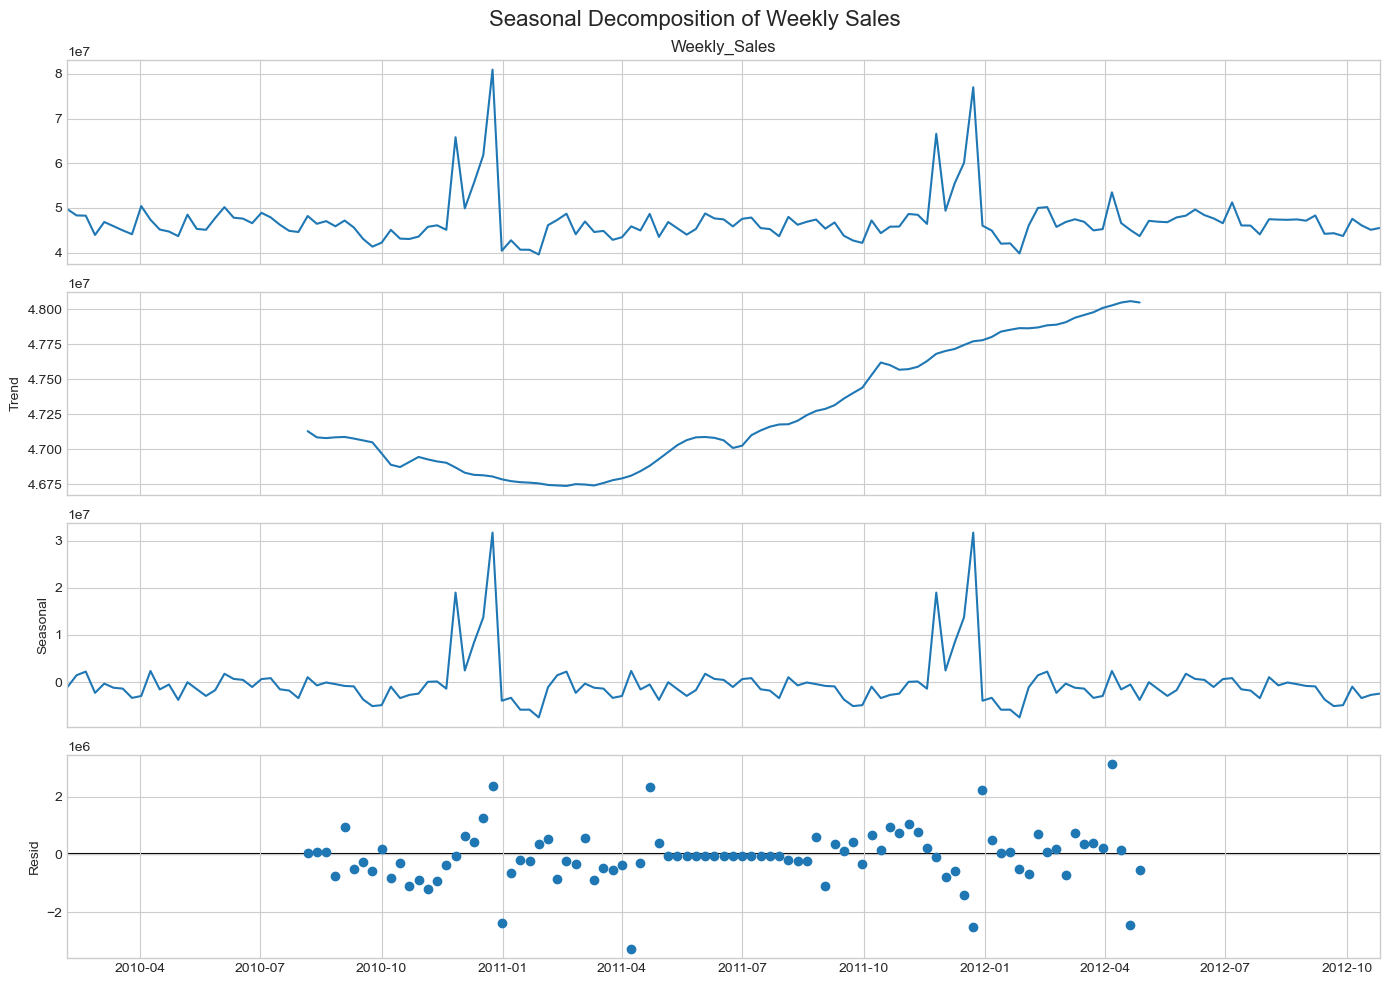

In [20]:
# Cell 7: Seasonal Decomposition (Optional Deep Dive)
result = seasonal_decompose(sales_ts["Weekly_Sales"], model='additive', period=52)
fig = result.plot()
fig.set_size_inches(14, 10)
plt.suptitle("Seasonal Decomposition of Weekly Sales", fontsize=16)
plt.tight_layout()
plt.show()

In [22]:
# Cell 8: Save Anomaly-Tagged Data (Optional)
output = sales_ts.copy()
output["anomaly_ml"] = features["anomaly_ml"]
output.to_csv("../data/processed/anomaly_detected.csv")
print("✅ Anomaly-tagged data saved to: ../data/processed/anomaly_detected.csv")

✅ Anomaly-tagged data saved to: ../data/processed/anomaly_detected.csv
